###Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Import Packages

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import itertools
import h5py
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



```
`# This is formatted as code`
```

###Set Data Paths

In [ ]:
Train_path = "/content/gdrive/MyDrive/Colab Notebooks/TractNET_Test_08/Data/train_points.txt"
Test_path = "/content/gdrive/MyDrive/Colab Notebooks/TractNET_Test_08/Data/test_points.txt"
Train_Label_path ="/content/gdrive/MyDrive/Colab Notebooks/TractNET_Test_08/Data/train_labels.txt"
Test_Label_path ="/content/gdrive/MyDrive/Colab Notebooks/TractNET_Test_08/Data/test_labels.txt"

###Load Data

In [ ]:
Train_Data = np.loadtxt(Train_path)
print(Train_Data.shape)
Train_Data = Train_Data.reshape(Train_Data.shape[0], Train_Data.shape[1] // 3,3)
print(Train_Data.shape)
Test_Data = np.loadtxt(Test_path)
print(Test_Data.shape)
Test_Data = Test_Data.reshape(Test_Data.shape[0], Test_Data.shape[1] // 3,3)
print(Test_Data.shape)
Train_labels=np.loadtxt(Train_Label_path)
Test_labels=np.loadtxt(Test_Label_path)

(52425, 768)
(52425, 256, 3)
(13102, 768)
(13102, 256, 3)


###Prepare Dataset

In [ ]:
NUM_POINTS = 256
NUM_CLASSES = 11
BATCH_SIZE = 32
CLASS_MAP={0: 'CSTL',
 1: 'CSTR',
 2: 'fornixL',
 3: 'fornixR',
 4: 'IFOFL',
 5: 'IFOFR',
 6: 'ILFL',
 7: 'ILFR',
 8: 'NON',
 9: 'UNCL',
 10: 'UNCR'}

def augment(points, label):
    # jitter points
    # points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

Train_Dataset = tf.data.Dataset.from_tensor_slices((Train_Data, Train_labels))
Test_Dataset = tf.data.Dataset.from_tensor_slices((Test_Data, Test_labels))

Train_Dataset = Train_Dataset.shuffle(len(Train_Data)).map(augment).batch(BATCH_SIZE)
Test_Dataset = Test_Dataset.batch(BATCH_SIZE)

###CNN Model

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)
    
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 16)
    x = conv_bn(x, 32)
    x = conv_bn(x, 256)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [3]:
inputs = keras.Input(shape=(5000, 3))
inputs

<KerasTensor: shape=(None, 5000, 3) dtype=float32 (created by layer 'input_2')>

###Create Model

In [ ]:
def create_model3(NUM_POINTS, NUM_CLASSES):
  # model = Sequential()
  inputs = keras.Input(shape=(NUM_POINTS, 3))

  x = tnet(inputs, 3)
  x = conv_bn(x, 16)
  x = conv_bn(x, 16)
  x = conv_bn(x, 16)
  x = conv_bn(x, 32)
  se1 = layers.GlobalMaxPooling1D(name="ch_pool1")(x)
  se1 = layers.Dense(8,activation="swish",kernel_initializer='he_normal', use_bias=False)(se1)
  se1 = layers.Dense(32,activation="sigmoid",kernel_initializer='he_normal', use_bias=False)(se1)
  x = layers.Multiply()([se1, x])
  x = conv_bn(x, 256)
  se2 = layers.GlobalMaxPooling1D(name="ch_pool2")(x)
  se2 = layers.Dense(16,activation="swish",kernel_initializer='he_normal', use_bias=False)(se2)
  se2 = layers.Dense(256,activation="sigmoid",kernel_initializer='he_normal', use_bias=False)(se2)
  x = layers.Multiply()([se2, x])
  x = layers.GlobalMaxPooling1D()(x)
  x = dense_bn(x, 128)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs, name="TractNET")
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.004)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
  model.summary()
  # plot_model(model,show_shapes=True, show_layer_names=True)

  return model

###Test Model

In [ ]:
create_model3(256,11)

Model: "TractNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 16)      64          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 16)      64          conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 16)      0           batch_normalization[0][0]        
___________________________________________________________________________________________

###Training

In [ ]:
epoches = 40
checkpoint_path = "/content/gdrive/MyDrive/Colab Notebooks/TractNET_Test_08/Save_Weights"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   monitor='val_sparse_categorical_accuracy',mode='max',
                                                 save_best_only=True, save_weights_only=True,
                                                 verbose=1)
model = create_model3(256,11)
history = model.fit(Train_Dataset, epochs=epoches, validation_data=Test_Dataset, callbacks=[cp_callback])

Model: "TractNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 3)]     0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 256, 16)      64          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 256, 16)      64          conv1d_8[0][0]                   
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 256, 16)      0           batch_normalization_10[0][0]     
___________________________________________________________________________________________

###Plot Graphs

In [ ]:
def plot_hist(hist):
    plt.figure(3)
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("sparse_categorical_accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    plt.figure(4)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

###Graph Results

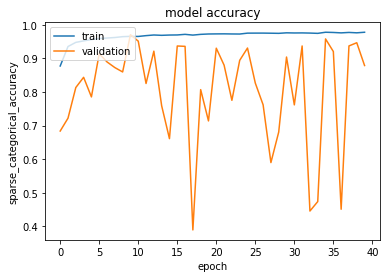

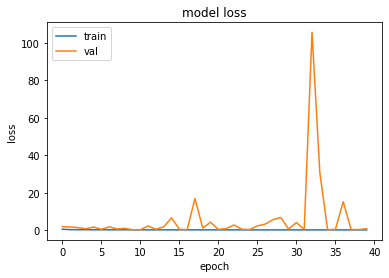

In [ ]:
plot_hist(history)

###Prediction Results

In [ ]:
results = model.evaluate(Test_Dataset,batch_size=32)
print('Current Model Accuracy:' ,results[1])

410/410 [==============================] - 4s 10ms/step - loss: 0.7986 - sparse_categorical_accuracy: 0.8788
Current Model Accuracy: 0.8787971138954163


In [ ]:
# Load best model
model_best = create_model3(256,11)
model_best.load_weights("/content/gdrive/MyDrive/Colab Notebooks/TractNET_Test_08/Save_Weights")
results = model_best.evaluate(Test_Dataset,batch_size=32)
print('Best Model Accuracy:' ,results[1])

Model: "TractNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 3)]     0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 256, 16)      64          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 256, 16)      64          conv1d_16[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 256, 16)      0           batch_normalization_20[0][0]     
___________________________________________________________________________________________

###Confusion Matrix

In [ ]:
test_labels= y = np.concatenate([y for x, y in Test_Dataset], axis=0)
print(test_labels)
predict_labels=model_best.predict(Test_Dataset,batch_size=32)
print(predict_labels.argmax(axis=1))
print('\nClassification Report\n')
print(classification_report(test_labels, predict_labels.argmax(axis=1), target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5',  'Class 6', 'Class 7', 'Class 8', 'Class 9',  'Class 10', 'Class 11']))
confusion = confusion_matrix(test_labels, predict_labels.argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

[ 0.  0.  0. ... 10. 10. 10.]
[ 0  0  0 ...  5 10 10]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.99      1.00      0.99      1191
     Class 2       0.99      0.99      0.99      1191
     Class 3       1.00      1.00      1.00      1191
     Class 4       0.98      1.00      0.99      1191
     Class 5       0.91      0.95      0.93      1191
     Class 6       0.92      0.99      0.96      1191
     Class 7       0.94      0.98      0.96      1192
     Class 8       0.99      0.99      0.99      1191
     Class 9       0.98      0.91      0.94      1191
    Class 10       1.00      0.94      0.97      1191
    Class 11       0.99      0.92      0.95      1191

    accuracy                           0.97     13102
   macro avg       0.97      0.97      0.97     13102
weighted avg       0.97      0.97      0.97     13102

Confusion Matrix

[[1189    0    0    0    0    0    0    0    2    0    0]
 [   0 1185    0    0    0    0  

In [ ]:
!jupyter nbconvert --to html /content/TractNET_Test_08.ipynb

[NbConvertApp] Converting notebook /content/TractNET_Test_08.ipynb to html
[NbConvertApp] Writing 444205 bytes to /content/TractNET_Test_08.html
